In [1]:
import pickle,sys,os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [2]:
!wget https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset0.pkl?raw=true

--2021-12-29 23:56:43--  https://github.com/GastonMazzei/TraceMeOut/blob/main/processed_trace/Dataset0.pkl?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/GastonMazzei/TraceMeOut/raw/main/processed_trace/Dataset0.pkl [following]
--2021-12-29 23:56:43--  https://github.com/GastonMazzei/TraceMeOut/raw/main/processed_trace/Dataset0.pkl
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GastonMazzei/TraceMeOut/main/processed_trace/Dataset0.pkl [following]
--2021-12-29 23:56:44--  https://raw.githubusercontent.com/GastonMazzei/TraceMeOut/main/processed_trace/Dataset0.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubuser

In [3]:
!ls

'Dataset0.pkl?raw=true'   sample_data


In [4]:
import pickle
with open('Dataset0.pkl?raw=true','rb') as f:
  data = pickle.load(f)

In [5]:

# Model-specific parameters
T=8 # duration of the window in dt units
dt = 100000 # time in microseconds
UNIQUES=3807  #number of unique ids
MI=5709  #max number of interactions
ML=5712  #max number of leaves
NCATEGORIES=2

# Architectural parameters
ACT1 = 'relu'
FILTERS1 = 8
KSIZE1 = (2,1)
PSIZE1 = (max([T//4,2]),)
NDENSE1 = 16
DROP1 = 0.4

ACT2 = 'relu'
FILTERS2 = 8
KSIZE2 = (2,2)
PSIZE2 = (max([T//2,2]),1)
stride = (1,1)
NDENSE2 = 16
DROP2 = 0.75

ACT3='relu'
NDENSE3=8
DROP3 = 0.4

# Training parameters
VAL=0.25
BATCH=10
EPOCHS=3
L=5 # a length used to generate random data just for testing

# Extras
POOLING = False
PROCS=[3, 2, 0, 1]

In [6]:
# define two sets of inputs: 
input_shape_flavours = (BATCH, T, ML, 1)
input_shape_structure = (BATCH, T, MI, 2)
inputFlavours = tf.keras.Input(shape=input_shape_flavours[1:])
inputStructure = tf.keras.Input(shape=input_shape_structure[1:])

# the first branch operates on the first input (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
x = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS1,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
			input_shape = input_shape_flavours[1:]
			)(inputFlavours)
x = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS1 * 2,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
			)(x)
x = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS1 * 2,         KSIZE1,       (1,1),      'valid',  activation = ACT1,
			)(x)
#x = tf.keras.layers.MaxPool1D(pool_size=PSIZE1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(DROP1)(x)
x = tf.keras.layers.Dense(NDENSE1, activation = ACT1)(x)
x = tf.keras.layers.Dropout(DROP1)(x)
x = tf.keras.layers.Dense(NDENSE1 // 2, activation = ACT1)(x)
x = tf.keras.layers.Dropout(DROP1)(x)
x = tf.keras.layers.Dense(NDENSE1 // 2 // 2, activation = ACT1)(x)
x = tf.keras.Model(inputs = inputFlavours, outputs=x)

# the second branch opreates on the second input (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
y = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS2,         KSIZE2,    stride,      'valid',  activation = ACT2,
			input_shape = input_shape_structure[1:]
			)(inputStructure)
y = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS2 * 2,         KSIZE2,       stride,      'valid',  activation = ACT2,
			)(y)
#y = tf.keras.layers.MaxPool2D(pool_size=PSIZE2)(y)
y = tf.keras.layers.Conv2D(
			# Filters, Kersize, Strides, Padding,  Activation
			FILTERS2 * 2,         KSIZE2,       stride,      'valid',  activation = ACT2,
			)(y)
y = tf.keras.layers.MaxPool2D(pool_size=PSIZE2)(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dropout(DROP2)(y)
y = tf.keras.layers.Dense(NDENSE2, activation = ACT2)(y)
y = tf.keras.layers.Dropout(DROP2)(y)
y = tf.keras.layers.Dense(NDENSE2 // 2, activation = ACT2)(y)
y = tf.keras.layers.Dropout(DROP2)(y)
y = tf.keras.layers.Dense(NDENSE2 // 2 // 2, activation = ACT2)(y)
y = tf.keras.Model(inputs = inputStructure, outputs=y)



# combine the output of the two branches
combined = tf.keras.layers.concatenate([x.output, y.output])
z = tf.keras.layers.Dropout(DROP3)(combined)
z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(z)
z = tf.keras.layers.Dropout(DROP3)(z)
z = tf.keras.layers.Dense(NDENSE3, activation = ACT3)(z)
z = tf.keras.layers.Dense(NCATEGORIES, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)

# Compile the model :-)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalCrossentropy(),
							                tf.keras.metrics.Accuracy(),
                       #tf.keras.metrics.AUC(),
											            ])


# Print input size and make fake dataset
print(model.summary())
IShape = model.input_shape
OShape = model.output_shape




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 5709, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 input_1 (InputLayer)           [(None, 8, 5712, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 5708, 8)   72          ['input_2[0][0]']                
                                                                                            

Finished building the output structure
Finished building the training dataset
Finished building the validation dataset
About to train! :-)
622/622 - 72s - loss: 0.6334 - categorical_crossentropy: 0.6334 - val_loss: 0.6968 - val_categorical_crossentropy: 0.6968 - 72s/epoch - 116ms/step
dict_keys(['loss', 'categorical_crossentropy', 'val_loss', 'val_categorical_crossentropy'])


KeyError: ignored

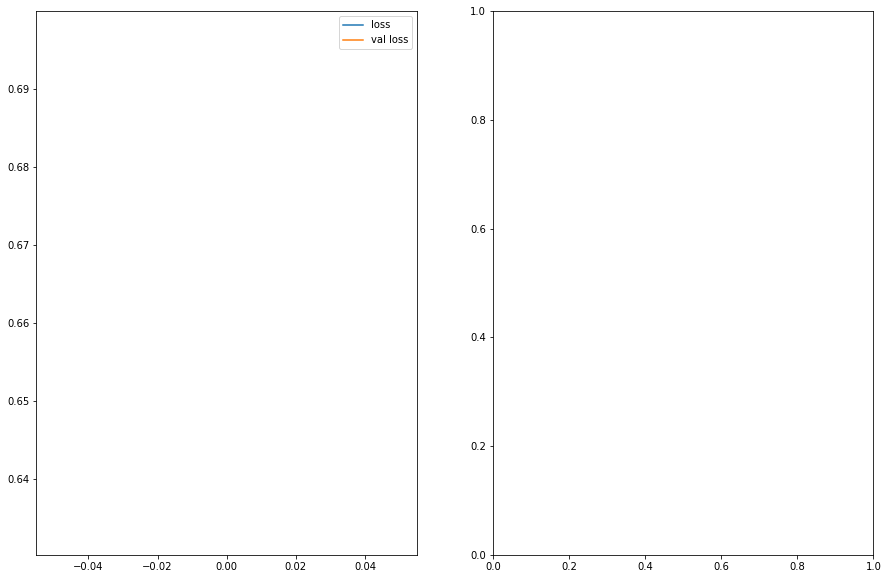

In [8]:


X1, X20, Y = data['X1'],data['X2'],data['Y']
ONE_HOT_Y = np.zeros((len(Y),2))
for i in range(len(Y)):
    ONE_HOT_Y[i,Y[i]] = 1
ONE_HOT_Y = ONE_HOT_Y.astype('float32')
L = len(X1)
LTR = int(L*(1-VAL))
B = 10
LTR = LTR//B * B # LTR is approximated to the closest multiple of B :-)
LVA = L - LTR
LVA = LVA // B * B # THe same for LVA
BATCH = BATCH // B * B # And the same for Batch Size

assert(len(X1)==len(X20)==len(Y))

X1_TRACKER = []
for X_ in X1:
    X1_TRACKER.append((ML-len(X_)))

X2 = [[] for _ in range(len(X20))]
X2_TRACKER = []
for i,X_ in enumerate(X20):
    c = 0
    for i_,y_ in enumerate(X_):
        for z in y_:
            X2[i] += [[float(i_),float(z)]]
            c += 1
    X2_TRACKER.append(MI-c) 


def produce_data(A,B):
    w = list(range(A,B))
    np.random.shuffle(w)
    for i in w:
            yield (
                    ( tf.convert_to_tensor(np.asarray([ (X1[j] + [0.] * X1_TRACKER[j]) for j in range(i-T+1,i+1)]).reshape(1,T,-1,1)), 
                      tf.convert_to_tensor(np.asarray([ (X2[j] + [[0., 0.]] * X2_TRACKER[j]) for j in range(i-T+1,i+1)]).reshape(1,T,-1,2)),
                    ), 
                    tf.convert_to_tensor(ONE_HOT_Y[i:i+1,:].reshape(1,2)),
                  )


OS = (
          (tf.TensorSpec(shape=(None,8,5712,1), dtype=tf.float32),
          tf.TensorSpec(shape=(None,8,5709,2), dtype=tf.float32)),
          tf.TensorSpec(shape=(None,2), dtype=tf.float32),
    )

print(f'Finished building the output structure')
trainD = tf.data.Dataset.from_generator(lambda: produce_data(T,LTR), output_signature=OS)#output_types=(tf.float32), output_shapes=OS)
print(f'Finished building the training dataset')
valD = tf.data.Dataset.from_generator(lambda: produce_data(LTR+T,L), output_signature=OS)# output_types=(tf.float32), output_shapes=OS)
print(f'Finished building the validation dataset')

print(f'About to train! :-)')
history = model.fit(trainD, epochs=1, batch_size=200, validation_data=valD, verbose=2)

print('Finished training! :-)')


No handles with labels found to put in legend.


dict_keys(['loss', 'categorical_crossentropy', 'val_loss', 'val_categorical_crossentropy'])


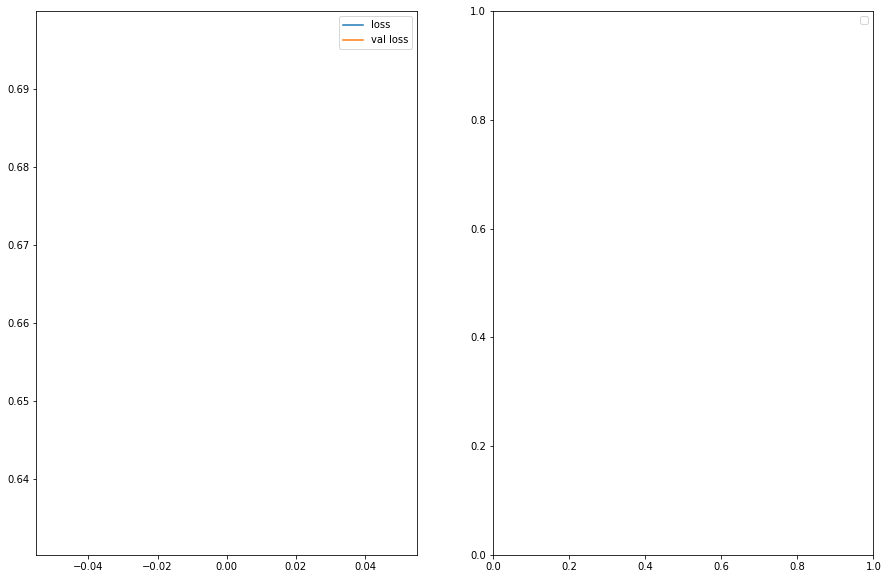

[0.6333986520767212] [0.6967979669570923]


In [10]:
# Display results
print(history.history.keys())
f,ax = plt.subplots(1,2,figsize=(15,10))
ax[0].plot(history.history['loss'],label='loss')
ax[0].plot(history.history['val_loss'], label='val loss')
ax[0].legend()
# ax[1].plot(history.history['auc'],label='auc')
# ax[1].plot(history.history['val_auc'], label='val auc')
ax[1].set_ylim(0,1)
ax[1].legend()																																																																																																																																																																				
plt.show()

print(history.history['loss'], history.history['val_loss'])